In [1]:
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.decomposition import SparsePCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [2]:
sns.set_style("whitegrid")
cwd = os.path.dirname(os.getcwd())
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
doc_dir = os.path.join(os.path.dirname(os.getcwd()), 'docs')

In [3]:
sfnc_pairs = sio.loadmat(os.path.join(data_dir,'sfnc_pairs.mat'))
sfnc_corr_pairs = sfnc_pairs['fnc_corrs']

In [4]:
demographics = pd.read_excel(os.path.join(data_dir, '20160420_vcalhoun_rest_demography_cag_info_new.xls'))

In [5]:
X = sfnc_corr_pairs
y = demographics.cap_d_group_id2.values

In [8]:
# Median split HD group based on cap_d_score: HD_near --> group with higher scores (more likely to develop symptoms sooner)
demographics["HD_near"] = (demographics.cap_d_score > demographics.cap_d_score.dropna().median())*1



In [59]:
# create HD_near and Control samples
X_near = X[demographics["HD_near"]==1]
X_controls = X[y==0]
y_near = np.ones(91)
y_controls = np.zeros(78)
# concatenate HD_near and controls
X_HD_near = pd.concat([pd.DataFrame(X_near), pd.DataFrame(X_controls)], axis=0)
y_HD_near = np.append(y_near, y_controls)

In [12]:
y_HD_near.sum()/np.shape(y_HD_near)[0] # ratio of HD vs Controls in the subgroup HD_near (and HD_far)

0.5384615384615384

In [66]:
# create HD_far and Control samples
X_far = X[demographics["HD_near"]==0]
X_far = X_far[y[demographics["HD_near"]==0]==1]
X_controls = X[y==0]
y_far = np.ones(92)
y_controls = np.zeros(78)
# concatenate HD_far and controls
X_HD_far = pd.concat([pd.DataFrame(X_far), pd.DataFrame(X_controls)], axis=0)
y_HD_far = np.append(y_far, y_controls)

In [34]:
# HD_near, Gradient boosting classifier
pipe = Pipeline([('PCA' , PCA(n_components=100,)),
    
                 ('classify', GradientBoostingClassifier(learning_rate=0.1,
                                       max_features='log2'))
                                    
                                    ])
            

N_ESTIMATORS = [100, 300, 500]
MAX_DEPTH = [1,2,3]
LOSS = ['deviance', 'exponential']
                
parameters = {'classify__n_estimators': N_ESTIMATORS, 
             'classify__max_depth': MAX_DEPTH,
                'classify__loss': LOSS}

clf = GridSearchCV(pipe,param_grid=parameters,  cv =10)
#clf.fit(X_HD_near, y_HD_near) non-nested
                
nested_score = cross_val_score(clf, X_HD_near, y_HD_near, cv=10)

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/s

In [35]:
print("Nested Score (accuracy): %f" %nested_score.mean())
print("Nested Score (accuracy) Standard deviation: %f" %nested_score.std())

Nested Score (accuracy): 0.558047
Nested Score (accuracy) Standard deviation: 0.123523


In [67]:
# HD_far, Gradient boosting classifier
pipe = Pipeline([('PCA' , PCA(n_components=100,)),
    
                 ('classify', GradientBoostingClassifier(learning_rate=0.1,
                                       max_features='log2'))
                                    
                                    ])
            

N_ESTIMATORS = [100, 300, 500]
MAX_DEPTH = [1,2,3]
LOSS = ['deviance', 'exponential']
                
parameters = {'classify__n_estimators': N_ESTIMATORS, 
             'classify__max_depth': MAX_DEPTH,
                'classify__loss': LOSS}

clf = GridSearchCV(pipe,param_grid=parameters,  cv =10)
                
nested_score = cross_val_score(clf, X_HD_far, y_HD_far, cv=10)

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/s

In [68]:
print("Nested Score (accuracy): %f" %nested_score.mean())
print("Nested Score (accuracy) Standard deviation: %f" %nested_score.std())

Nested Score (accuracy): 0.551185
Nested Score (accuracy) Standard deviation: 0.096909


In [38]:
# HD near Logistic regression
pipe = Pipeline([('PCA' , PCA(n_components=100,)),
    
                 ('classify', LogisticRegression())
                                    
                                    ])
            
            

PENALTY = ['l1', 'l2']
C = [0.001, 0.1,1,10, 100]
                
parameters = {'classify__penalty': PENALTY, 
             'classify__C': C,}

clf = GridSearchCV(pipe,param_grid=parameters,  cv =10)
                
nested_score = cross_val_score(clf, X_HD_near, y_HD_near, cv=10)

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWa

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

In [39]:
print("Nested Score (accuracy): %f" %nested_score.mean())
print("Nested Score (accuracy) Standard deviation: %f" %nested_score.std())

Nested Score (accuracy): 0.614461
Nested Score (accuracy) Standard deviation: 0.109150


In [71]:
# HD far Logistic regression
pipe = Pipeline([('PCA' , PCA(n_components=100,)),
    
                 ('classify', LogisticRegression())
                                    
                                    ])
            
            

PENALTY = ['l1', 'l2']
C = [0.001, 0.1,1,10, 100]
                
parameters = {'classify__penalty': PENALTY, 
             'classify__C': C,}

clf = GridSearchCV(pipe,param_grid=parameters,  cv =10)
                
nested_score = cross_val_score(clf, X_HD_far, y_HD_far, cv=10)

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWa

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

In [72]:
print("Nested Score (accuracy): %f" %nested_score.mean())
print("Nested Score (accuracy) Standard deviation: %f" %nested_score.std())

Nested Score (accuracy): 0.562092
Nested Score (accuracy) Standard deviation: 0.124346


Optimal number of features : 348


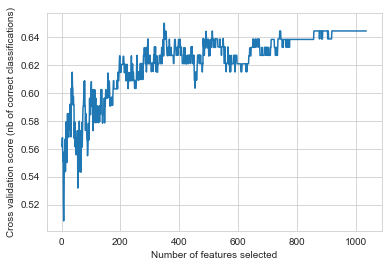

In [24]:
# Create the RFE object and compute a cross-validated score: Taken from here: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(X_HD_near, y_HD_near)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [30]:
# Function for stepwise selection, taken from here: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.3, 
                       threshold_out = 0.5, 
                       verbose=True, top_n=None):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if top_n is not None and top_n == len(included):
            break
    return included

In [31]:
# perform stepwise regression in a cross-validated framework --> gets stuck
clf = LogisticRegression()


accs, coefs = [], []
all_sel_cols = []
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X_HD_near, y_HD_near)

for train_index, test_index in skf.split(X_HD_near, y_HD_near):
       print("TRAIN:", train_index, "TEST:", test_index)
       X_train, X_test = X_HD_near.iloc[train_index,:], X_HD_near.iloc[test_index,:]
       y_train, y_test = y_HD_near[train_index], y_HD_near[test_index]
       sel_w_pvals = stepwise_selection(
                pd.DataFrame(X_train, columns=X_HD_near.columns),
                    y_train, verbose=False,top_n=20)  # ~1/3 of available samples
       #print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))
       sel_vars_inds = np.isin(X_HD_near.columns, sel_w_pvals)

       clf.fit(X_train.loc[:, sel_vars_inds], y_train)

       coefs.append(clf.coef_)
       accs.append(clf.score(X_test.loc[:, sel_vars_inds], y_test))
       all_sel_cols += sel_w_pvals
       print(np.mean(accs))

TRAIN: [ 46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129]


/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a fut

0.6352941176470588
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129] TEST: [ 46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168]


/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


0.6093137254901961


/Users/anna/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
